# Importación de librerias

In [1]:
import numbers
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.svm import SVC, OneClassSVM
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint

# Definición del método para evaluar mejor modelo

In [2]:
def evaluate_Model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy )
    return accuracy

# Definición del método para el cálculo del AUC

In [3]:
"""
Método para el cálculo del Area Under the Curve
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
imposter_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
AUC: area bajo la curva ROC
"""
def evaluate_AUC(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    auc_score = roc_auc_score(labels, genuine_scores + impostor_scores)
    return auc_score

In [4]:
"""
Método para el cálculo del ERR
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
imposter_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
Equal Error Rate: punto donde los missrates y los far
"""
#Primera forma de hallar el ERR
def evaluate_EER(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    #Variable con los False Negative Rate (FNR) - miss
    missrates = 1 - tpr
    
    #Variable con los False Positive Rate (FPR) - false alarm
    farates = fpr
    
    #Se hallan las distancias entre los FNR y FPR dado cierto umbral
    dists = missrates - farates
    
    #Listas que separan las distancias con los valores 
    #que estan más cercano al cero tanto superior como inferior
    tempList1 = dists[dists >= 0]
    tempList2 = dists[dists < 0]
    
    #Se busca el punto en la curva ROC donde se interceptan geométricamente el FNR y FPR
    #El primero que sea el cercano superior al false alarm (>=)
    #y aquel que este pegado a este en la curva pero siendo el cercano inferior (<)
    # argmin te arroja el indice el item con los menores valores
    # argmax te arroja el indice el item con los mayores valores
    #idx es una variable que almacena este índice
    
    #Indice del menor elemento del tempList1 (Lo más pegado al cero superiormente)
    idx1 = np.argmin(tempList1)
    #Sacar el indice del valor de idx1 (en tempList1), pero en la lista "dists"
    idx1, = np.where(dists == tempList1[idx1])
    
    #Indice del mayor elemento del tempList2 (Lo más pegado al cero inferiormente)
    idx2 = np.argmax(tempList2)
    #Sacar el indice del valor de idx2 (en tempList2), pero en la lista "dists"
    idx2, = np.where(dists == tempList2[idx2])
    
    #Se determina es valor de los dos puntos y ponerlo en la variable x e y
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]

    #encuentrar el punto en la línea entre x e y en donde 
    #los primeros y segundos elementos del vector sean iguales.
    #Específicamente, la línea que pasa a través de x e y 
    #se define como x + a * (y-x) para todo "a"
    #Si usamos esta formula y lo igualamos, ya q x e y 
    #deben de coincidir en ese punto de la recta
    #  -> x[1] + a*(y[1]-x[1]) = x[2] + a*(y[2]-x[2])
    #lo factorizamos para determinar a
    #que seria la pendiente de la recta que construiremos
    #  -> a = (x[1] - x[2]) / (y[2]-x[2]-y[1]+x[1]) 
    
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )
    
    return eer


#Segunda forma de hallar el EER.
def evaluate_EER_Thresh(genuine_scores, impostor_scores):
    
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1]*len(genuine_scores) + [0]*len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    #Se calcula el EER cuando el punto del fpr y del fpr se encuentran
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

# Definición del método para graficar curva ROC

In [5]:
def plotCurveROC(genuine_scores, imposter_scores, title = 'Receiver Operating Characteristic'):
    
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(imposter_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = 1)
    
    roc_auc = evaluate_AUC(genuine_scores, imposter_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Lectura de archivo y eliminación de registros no válidos
Se eliminan los registros que NO hayan escrito la palabra greyc laboratory

In [6]:
#Se define la ruta donde se encuentra el archivo y se establece la conexión
path = "./data/grey/keystroke.db"
conn = sqlite3.connect(path)

#Se hace la lectura y se almacena los datos extraídos en la variable df ("dataframe")
df = pd.read_sql_query('select * from keystroke_datas', conn, parse_dates=['date'])

#Se eliminan los registros de los usuarios que no hallan escrito la palabra 'greyc laboratory'
df.drop(df[df['password'] != 'greyc laboratory'].index, inplace = True)

#Se hace un cierre de la conexión con la base de datos SQLite
conn.close()

# Previsualización del dataset original
 El siguiente dataset contiene las siguientes columnas:
  - ppTime: vector de tiempo entre dos teclas presionadas (press - press)
  - rrTime: vector de tiempo entre dos teclas soltadas (release - release)
  - prTime: vector de tiempo entre una tecla presionada y luego soltada (press - release)
  - rpTime: vector de tiempo entre una tecla soltada y luego presionada (release - press)
  - vector: este vector concatena todos los vectores anteriores en uno solo
  - password: palabra escrita  por el usuario
  - user_id: id del usuario
  - time_to_type: tiempo que tardo en escribir la palabra
  - rawPress: data cruda extraida de las teclas presionadas
  - rawRelease: data cruda extraida de las teclas soltadas  

In [7]:
df.head(5)

,id,ppTime,rrTime,prTime,rpTime,vector,password,user_id,date,time_to_type,rawPress,rawRelease
5,6,2203168 600864 1101584 1602304 801152 2303312...,2203168 901296 500720 2503600 600864 1902736 ...,3204608 1902736 1802592 3204608 2203168 33047...,1201728 -400576 -200288 901296 -801152 901296...,2203168 600864 1101584 1602304 801152 2303312...,greyc laboratory,1,2009-03-18 08:49:09,30644064,71 633729665463844160\n82 633729665466047328\n...,71 633729665464845600\n82 633729665467048768\n...
6,7,2103024 500720 2703888 1602304 2103024 340489...,1902736 701008 2203168 1802592 2203168 310446...,3104464 1702448 3404896 2503600 3104464 41059...,901296 -500720 1502160 901296 1201728 2403456...,2103024 500720 2703888 1602304 2103024 340489...,greyc laboratory,1,2009-03-18 08:49:18,33748528,71 633729665547564544\n82 633729665549667568\n...,71 633729665548766272\n82 633729665550669008\n...
7,8,2203168 701008 1402016 1301872 2303312 330475...,2503600 801152 901296 1602304 2203168 3104464...,3304752 1902736 2103024 2303312 3204608 40057...,1402016 -400576 200288 600864 1301872 2403456...,2203168 701008 1402016 1301872 2303312 330475...,greyc laboratory,1,2009-03-18 08:49:28,29442336,71 633729665651914592\n82 633729665654117760\n...,71 633729665652715744\n82 633729665655219344\n...
8,9,2103024 701008 1902736 1702448 1602304 260374...,2303312 701008 1402016 2002880 1602304 240345...,3304752 1902736 2603744 2703888 2603744 34048...,1101584 -500720 701008 1001440 600864 1602304...,2103024 701008 1902736 1702448 1602304 260374...,greyc laboratory,1,2009-03-18 08:49:48,31545360,71 633729665853404320\n82 633729665855507344\n...,71 633729665854405760\n82 633729665856709072\n...
9,10,2002880 600864 1201728 1602304 1502160 300432...,2002880 901296 701008 1802592 1502160 2703888...,2904176 1802592 1902736 2503600 2403456 36051...,1101584 -300432 0 901296 600864 2103024 50072...,2002880 600864 1201728 1602304 1502160 300432...,greyc laboratory,1,2009-03-18 08:49:58,29642624,71 633729665954750048\n82 633729665956752928\n...,71 633729665955651344\n82 633729665957654224\n...


# Preprocesamiento de vectores de tiempo

In [8]:
#Variable temporal para almacenar los items de la columna vector
#ya que no se puede trabajar directamente con ese formato
tempData = []

#Variable con la cantidad de registros totales de la bd
n_data_rows = df.shape[0]

#Variable que tendrá la lista de columnas del dataframe
columns = ["user_id"]   

#Como existen en total 60 features de tiempo por usuario, se generará 
#los nombres de las columnas siguiento el siguiente formato 
#=> 'ft_'   +  posición del feature en el vector
for i in range(60):
    columns.append("ft_" + str(i+1))

#Por cada registro que existe en la bd se aplica lo siguente
for i in range(n_data_rows):
    
    #Se extrae el usuario de ese registro
    user_id = [df.iloc[i]["user_id"]]
    #Se extrae el tiempo de tecleo
    time_to_type = [df.iloc[i]["time_to_type"]]
    
    #Se crea el vector de tiempo
    vector = df.iloc[i]["vector"].split()      
 
    #Se verifica que la integridad del vector este OK,
    #es decir que tenga una longitud exacta de 60 items
    if(len(vector) == 60 ):
        #Se aprega el registro a la variable temporarl tempData si cumple con la condición de integridad
        tempData.append(user_id  + list(map(int, vector)))

#Se crea el dataframe y se asigna a la variable df
df = pd.DataFrame(tempData, columns = columns)

#Se liberan recursos de la variable
tempData.clear()

## Previsualización de dataset procesado
Por cada registro, se tienen las siguientes columnas
 - Los features entre el 1 y 12 corresponden al vector de tiempo ppTime
 - Los features entre el 13 y 25 corresponden al vector de tiempo rrTime
 - Los features entre el 26 y 37 corresponden al vector de tiempo prTime
 - Los features entre el 38 y 60 corresponden al vector de tiempo rpTime

In [9]:
df.head(5)

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
0,1,2203168,600864,1101584,1602304,801152,2303312,1001440,2603744,1402016,...,3304752,2002880,3605184,2002880,2804032,2403456,2904176,2403456,2303312,2103024
1,1,2103024,500720,2703888,1602304,2103024,3404896,1402016,2603744,1402016,...,4105904,2303312,3505040,2103024,2203168,2603744,2804032,2603744,3104464,2103024
2,1,2203168,701008,1402016,1301872,2303312,3304752,901296,3004320,1502160,...,4005760,1902736,3905616,2203168,2303312,3104464,2603744,2203168,2203168,2603744
3,1,2103024,701008,1902736,1702448,1602304,2603744,1502160,3004320,1502160,...,3404896,2703888,4005760,2203168,2303312,2403456,3104464,2103024,2904176,2403456
4,1,2002880,600864,1201728,1602304,1502160,3004320,1101584,2904176,1602304,...,3605184,2203168,3905616,2303312,2603744,3104464,2603744,1902736,2503600,2203168


# Separación de la data de entrenamiento y de prueba
Se toma de forma aleatoria el 80% de los registros de cada usuario para considerarlos como data de entrenamiento, el 10%  para la data de desarrollo del umbral y el 10 % restante para la data de prueba


La función train_test_split cuando existe un grupo impar, siempre el último subgrupo recibe el elemento extra.
Se trató de redondear el 0.80 del parámetro **train_size** debido a que cuando se trabaja con esta cantidad, arrojaba una mayor cantidad de splits con subdatasets de dev y de test desiguales. Aproximandamente **73**
![Resultados usando una proporcion de 80](./img/Proportion%20split%2080.png)

Poner 0.84 en el parámetro **train_size** permite tener menores grupos de subdatasets de dev y de test desiguales. En este solo se obtienen **4** de este tipo.
> Se debe de mantener que el dataset de dev sea lo más similar al de test.

[Link de fuente](https://cs230.stanford.edu/blog/split/)

![Resultados usando una proporcion de 84](./img/Proportion%20split%2084.png)

In [10]:
#Variable que contiene la lista de todos los usuarios de la bd
subjects = df["user_id"].unique()

#Variable del dataset de train 80%
train_users = []

#Variable del dataset de dev (desarrollo) para el calculo del umbral 10%
dev_users = []

#Variable del dataset de test 10%
test_users = []

#Separar el df en 80 / 10 / 20 respectivamente y asignarlo a sus 
for subject in subjects:
    current_user_data = df.loc[df.user_id == subject, :]
            
    #imposter_data = df.loc[df.user_id != subject, :]
    
    #Caso especial de una proporcion de 60/20/20 cuando el usuario tiene solo 5 registros
    #Para no eliminar ese registro y no lanze error 
    #Donde quedaría asi 5 -> 3 / 1 / 1

    if len(current_user_data) == 5:
        train, dev = train_test_split(current_user_data, train_size = 0.6, random_state=43, shuffle=True)
        dev , test = train_test_split(dev, train_size = 0.5, random_state=43, shuffle=True)
    
    #Caso contrario se respeta la proporcion de 80/10/10 establecida antes
    else:
        train, dev = train_test_split(current_user_data, train_size = 0.80, random_state=43, shuffle=True)
        dev , test = train_test_split(dev, train_size = 0.5, random_state=43, shuffle=True)
        
    #Se agregan a los 3 datasets los splits calculados aleatoriamente
    train_users.append(train)
    dev_users.append(dev)
    test_users.append(test)

#Se convierte los arrays en dataframes manipulables
train_users = pd.concat(train_users)
dev_users = pd.concat(dev_users)
test_users = pd.concat(test_users)

### Previsualización del dataset de entrenamiento

In [11]:
train_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
4797,1,2103024,701008,2603744,1001440,1001440,2002880,500720,2403456,1402016,...,3004320,1702448,3605184,2203168,2703888,1602304,2203168,1702448,3404896,1602304
12,1,2403456,600864,1402016,1602304,801152,2103024,1201728,3004320,1702448,...,3204608,2303312,4306192,2503600,2603744,2703888,2703888,2103024,2603744,2203168
3959,1,1902736,701008,1001440,801152,1001440,1902736,500720,2603744,901296,...,2603744,1702448,3404896,1602304,2904176,2403456,2103024,1402016,2503600,1602304
6799,1,2002880,701008,1001440,1301872,1001440,2103024,1702448,1602304,2904176,...,2904176,2804032,2403456,4005760,3304752,2603744,2603744,1802592,2703888,1902736
2222,1,2103024,701008,901296,1201728,701008,2403456,1001440,2103024,1402016,...,3404896,1902736,3304752,2103024,3104464,2703888,2503600,1602304,3004320,1702448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483,133,3304752,2403456,2303312,1902736,1702448,2203168,2103024,1902736,2403456,...,3404896,3004320,3104464,3304752,6409216,3104464,3304752,1902736,2403456,3705328
7480,133,1902736,2002880,2103024,2103024,1702448,3905616,1902736,2303312,2203168,...,4706768,2804032,3304752,3104464,2804032,3204608,7711088,3404896,2503600,3905616
7481,133,2203168,1802592,2203168,1602304,1402016,2603744,2203168,2103024,1602304,...,3805472,3204608,3004320,2804032,2904176,2804032,5207488,2603744,2603744,3505040
7308,133,1902736,2002880,1902736,2002880,1902736,5608064,1802592,1201728,1902736,...,6409216,2603744,2002880,3104464,3304752,3605184,5107344,2603744,3004320,3805472


### Previsualización del dataset de desarrollo

In [12]:
dev_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
11,1,2203168,400576,2703888,1802592,1702448,2904176,1301872,3104464,1201728,...,3605184,2303312,4105904,2203168,2403456,2503600,2603744,2203168,2703888,2103024
4789,1,1902736,701008,1502160,1101584,701008,2403456,1001440,2103024,1201728,...,3605184,2203168,3304752,2103024,3304752,2503600,2403456,1702448,3004320,2303312
2323,1,2203168,701008,1301872,1101584,801152,2303312,500720,2503600,1502160,...,3304752,1802592,3705328,2303312,3004320,2904176,2703888,2203168,2703888,2503600
8,1,2103024,600864,1201728,1702448,3104464,2403456,1402016,3505040,1502160,...,3204608,2503600,4406336,2203168,2403456,2503600,2703888,1802592,2603744,2503600
0,1,2203168,600864,1101584,1602304,801152,2303312,1001440,2603744,1402016,...,3304752,2002880,3605184,2002880,2804032,2403456,2904176,2403456,2303312,2103024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7148,132,2103024,1502160,1802592,1602304,1602304,2904176,1602304,1402016,1902736,...,3705328,2603744,2203168,2603744,3304752,2303312,1201728,3805472,3605184,2904176
7359,132,2103024,1201728,1602304,1602304,1702448,2603744,1402016,1802592,1402016,...,3404896,2403456,2403456,2203168,3404896,2403456,1402016,5507920,3605184,10314832
7140,132,2303312,1502160,2203168,1802592,2002880,3805472,1402016,1902736,1702448,...,4506480,2503600,2804032,2503600,3705328,2703888,1902736,6909936,3004320,4105904
7314,133,1902736,2103024,5608064,2804032,1301872,1902736,1402016,1702448,2103024,...,3004320,2603744,2804032,3304752,3104464,2904176,3605184,2403456,2303312,3605184


### Previsualización del dataset de prueba

In [13]:
test_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
6795,1,2503600,400576,1902736,1201728,701008,2203168,1301872,2303312,2804032,...,3104464,2603744,3404896,3705328,3204608,2403456,2904176,1902736,3204608,2303312
3954,1,1702448,701008,1101584,901296,701008,2002880,500720,2303312,901296,...,2804032,1602304,3404896,1702448,2804032,2203168,2203168,1602304,2603744,1502160
6802,1,1902736,701008,1502160,1101584,901296,2203168,1201728,1902736,2603744,...,3204608,2403456,2904176,3304752,2904176,2603744,2303312,1101584,2804032,1602304
405,1,1602304,901296,901296,1702448,901296,1802592,1201728,2603744,1402016,...,3004320,2303312,4206048,2403456,3104464,2603744,2503600,2403456,2503600,2303312
4791,1,2503600,801152,2103024,1201728,1001440,2103024,1201728,2403456,1802592,...,3004320,2403456,3805472,2503600,3104464,2804032,2804032,1702448,3505040,1902736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6751,132,2002880,1402016,1602304,1802592,1602304,2804032,1602304,1502160,2103024,...,3605184,2804032,2203168,2904176,3304752,2603744,1702448,5307632,3705328,3404896
6754,132,2103024,1702448,1902736,1402016,1702448,2804032,1902736,1602304,2002880,...,3805472,2804032,2603744,2904176,3605184,2403456,1902736,4306192,3505040,2403456
7477,133,2103024,2904176,3505040,3805472,1201728,2103024,4806912,1402016,2603744,...,3304752,5808352,2603744,3805472,2403456,3505040,4206048,2904176,2804032,3905616
7313,133,2203168,1802592,1702448,1201728,1902736,1902736,2103024,1402016,4005760,...,3304752,3004320,1902736,5007200,4306192,4005760,3805472,2703888,3204608,4105904


# Cálculo de las probablidades con los registros de test

![Calculo de distancias](./img/Calculo%20de%20distancias.png)

### Ejemplo del usuario 1

### Separación de los datos a usar para el usuario 1

#### Aca obtenemos el X_train, y_train del usuario 1

In [14]:
#Generamos una copia temporal del dataset de entrenamiento
temp1 = train_users.copy()

#Reemplazamos todos los users_ids que son distintos al usuario 1 por 0
temp1["user_id"] = temp1["user_id"].mask(temp1["user_id"] != 1, 0)

#Obtenemos los registros considerados genuinos del entrenamiento
genuine_data = temp1.loc[temp1.user_id == 1, :]

#Obtenemos los registros considerados impostores del entrenamiento.
#Este debe de ser del mismo tamaño que de los registros genuinos
impostor_data = temp1.loc[temp1.user_id != 1, :].sample(n= genuine_data.shape[0], random_state=43)

#Lo unimos los dos anteriores en un solo dataset de entrenamiento del modelo del usuario 1
train = pd.concat([genuine_data, impostor_data])

#Obtenemos el X_train
X_train = train.loc[:, "ft_1":"ft_60" ]

#Obtenemos el y_train
y_train = train.loc[:, "user_id"]

#### Obtenemos el X_dev , y_dev, X_test y y_test del usuario 1

In [15]:
#Generamos una copia temporal del dataset de desarrollo
temp2 = dev_users.copy()

#Reemplazamos todos los users_ids que son distintos al usuario 1 por 0
temp2["user_id"] = temp2["user_id"].mask(temp2["user_id"] != 1, 0)

#df.sample(frac=0.5, replace=True, random_state=1)
X_dev = temp2.loc[:, "ft_1":"ft_60"]
y_dev = temp2.loc[:, "user_id"]

#------------------------------------------------------------------

#Generamos una copia temporal del dataset de test
temp3 = test_users.copy()

#Reemplazamos todos los users_ids que son distintos al usuario 1 por 0
temp3["user_id"] = temp3["user_id"].mask(temp3["user_id"] != 1, 0)

X_test = temp3.loc[:, "ft_1":"ft_60"]
y_test = temp3.loc[:, "user_id"]

### Realizamos la busqueda de los mejores hiperparámetros
Comenzamos con un Grid Search para hallar los mejores hiperparametros

In [16]:
#Creamos un modelo SVC
svc = SVC()

#Mostramos parametros por default
pprint(svc.get_params())

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [17]:
C = [x for x in np.geomspace(0.01, 100000, num=8)]
kernel = ['linear', 'rbf']
gamma = [x for x in np.geomspace(1, 0.000000001, num=10)]
gamma.append('scale')

param_grid = {
    'C': C, 
    'gamma': gamma,
    'kernel': kernel}

#Hiperparametros a evaluar
pprint(param_grid)

{'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
 'gamma': [1.0,
           0.1,
           0.01,
           0.001,
           0.0001,
           1e-05,
           1e-06,
           1e-07,
           1e-08,
           1e-09,
           'scale'],
 'kernel': ['linear', 'rbf']}


In [18]:
#Realizamos el grid search
grid_search  = GridSearchCV(SVC(), param_grid, verbose=1, cv = 5, n_jobs = -1)

grid_search .fit(X_train,y_train)

#Mejores hiperparametros
grid_search.best_params_

#Accuracy
#grid_search.best_score_

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:    2.2s finished


{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}

### Resultados con los parámetros por default

In [19]:
base_model = SVC()
base_model.fit(X_train,y_train)
base_accuracy = evaluate_Model(base_model, X_dev, y_dev)

Accuracy: 0.9743935309973046


### Resultados con los parámetros encontrados por el Grid Search Cross Validation

In [20]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate_Model(best_grid, X_dev, y_dev)

Accuracy: 0.9905660377358491


### Entrenamiento del modelo con mejores hiperparametros  

In [21]:
#Entrenamos el modelo SVC
clf = SVC(C = 10.0, gamma = 'scale', kernel = 'rbf', probability = True)

clf.fit(X_train,y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
#Obtenemos las predicciones
y_pred = clf.predict(X_test)

### Resultado con el subdataset de prueba del usuario 1

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9766871165644172


### Calculo de las probabilidades de cada registro usando el modelo del usuario 1

In [24]:
#Con la función predict_proba obtenemos las probabilidades para cada clase.
#En el primero, obtenemos la probalidad de que sea un registro de un usuario impostor
#En el otro, obtenemos la probalidad de que el registro pertenesca al usuario 1 (legitimo)
y_prob = clf.predict_proba(X_test)
y_prob = pd.DataFrame(y_prob, columns = ["probImpos", "probLegi"])
y_prob

,probImpos,probLegi
0,0.003070,0.996930
1,0.024810,0.975190
2,0.009094,0.990906
3,0.024014,0.975986
4,0.004649,0.995351
...,...,...
810,0.991955,0.008045
811,0.991235,0.008765
812,0.994450,0.005550
813,0.985228,0.014772


In [25]:
#Variable donde se almacenará toda la informacion calculada del usuario 1 
user_1_evaluation = []

i = 0

#Para cada registro del subdataset de test
for index, row in test_users.iterrows():
    
    temp_obj = {}
    
    #user id del registro actual del subdataset de test
    current_user_id = row[0]
    
    #Vector de tiempo del registro actual del subdataset de test
    current_data = row[1:]
    
    #Actual modelo del usuario a evaluar
    temp_obj["user_model"] = 1

    #user id del registro actual
    temp_obj["user_id"] = current_user_id
    
    #Puntaje o score del modelo
    temp_obj["score"] = y_prob.iloc[i]["probLegi"]

    #Normalizacion del score
    temp_obj["std_score"] = y_prob.iloc[i]["probLegi"]
    
    #Variable que indica si el registro deberia de ser clasificado como geniono o impostor
    if current_user_id == 1:
        temp_obj["y_test"] = "genuine"
    else:
        temp_obj["y_test"] = "impostor"
    
    user_1_evaluation.append(temp_obj)
    
    i += 1
    
user_1_evaluation = pd.DataFrame(user_1_evaluation)

### Puntaje de los registros del subdataset de test usando el modelo del usuario 1
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id **(1)** coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [26]:
user_1_evaluation

,user_model,user_id,score,std_score,y_test
0,1,1,0.996930,0.996930,genuine
1,1,1,0.975190,0.975190,genuine
2,1,1,0.990906,0.990906,genuine
3,1,1,0.975986,0.975986,genuine
4,1,1,0.995351,0.995351,genuine
...,...,...,...,...,...
810,1,132,0.008045,0.008045,impostor
811,1,132,0.008765,0.008765,impostor
812,1,133,0.005550,0.005550,impostor
813,1,133,0.014772,0.014772,impostor


### Cálculo usando los modelos de todos los usuarios

In [27]:
users_evaluation = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #----------------------------------------------------------------
    #Generamos una copia temporal del dataset de entrenamiento
    temp1 = train_users.copy()

    #Reemplazamos todos los users_ids que son distintos al sujeto actual por 0
    temp1["user_id"] = temp1["user_id"].mask(temp1["user_id"] != subject, 0)

    #Obtenemos los registros considerados genuinos del entrenamiento
    genuine_data = temp1.loc[temp1.user_id == subject, :]

    #Obtenemos los registros considerados impostores del entrenamiento.
    #Este debe de ser del mismo tamaño que de los registros genuinos
    impostor_data = temp1.loc[temp1.user_id != subject, :].sample(n= genuine_data.shape[0], random_state=43)

    #Unimos los dos anteriores variables en un solo dataset de entrenamiento del modelo
    train = pd.concat([genuine_data, impostor_data])

    #Obtenemos el X_train
    X_train = train.loc[:, "ft_1":"ft_60" ]

    #Obtenemos el y_train
    y_train = train.loc[:, "user_id"]
    
    #----------------------------------------------------------------
    
    #Generamos una copia temporal del dataset de desarrollo
    temp2 = dev_users.copy()

    #Reemplazamos todos los users_ids que son distintos al usuario 1 por 0
    temp2["user_id"] = temp2["user_id"].mask(temp2["user_id"] != subject, 0)

    #df.sample(frac=0.5, replace=True, random_state=1)
    X_dev = temp2.loc[:, "ft_1":"ft_60"]
    y_dev = temp2.loc[:, "user_id"]

    #----------------------------------------------------------------

    #Generamos una copia temporal del dataset de test
    temp3 = test_users.copy()

    #Reemplazamos todos los users_ids que son distintos al usuario 1 por 0
    temp3["user_id"] = temp3["user_id"].mask(temp3["user_id"] != subject, 0)

    X_test = temp3.loc[:, "ft_1":"ft_60"]
    y_test = temp3.loc[:, "user_id"]
    
    #----------------------------------------------------------------
    
    #Entrenamos el modelo SVM
    
    clf = SVC(C = 10.0, gamma = 'scale', kernel = 'rbf', probability = True)
    #clf = SVC(probability = True)
    
    clf.fit(X_train,y_train)
    
    #Obtenemos probabilidades de cada registro del dataset de test
    y_prob = clf.predict_proba(X_test)
    y_prob = pd.DataFrame(y_prob, columns = ["probImpos", "probLegi"])

    i = 0

    #Para cada registro del subdataset de test
    for index, row in test_users.iterrows():

        temp_obj = {}

        #user id del registro actual del subdataset de test
        current_user_id = row[0]

        #Vector de tiempo del registro actual del subdataset de test
        current_data = row[1:]

        #Actual modelo del usuario a evaluar
        temp_obj["user_model"] = subject

        #user id del registro actual
        temp_obj["user_id"] = current_user_id

        #Puntaje o score del modelo
        temp_obj["score"] = y_prob.iloc[i]["probLegi"]

        #Normalizacion del score
        temp_obj["std_score"] = y_prob.iloc[i]["probLegi"]

        #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
        if current_user_id == subject:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation.append(temp_obj)

        i += 1

users_evaluation = pd.DataFrame(users_evaluation)

### Puntaje de los registros del subdataset de test usando todos los modelos
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [28]:
users_evaluation

,user_model,user_id,score,std_score,y_test
0,1,1,0.999992,0.999992,genuine
1,1,1,0.983240,0.983240,genuine
2,1,1,0.994465,0.994465,genuine
3,1,1,0.983834,0.983834,genuine
4,1,1,0.997355,0.997355,genuine
...,...,...,...,...,...
108390,133,132,0.106594,0.106594,impostor
108391,133,132,0.040755,0.040755,impostor
108392,133,133,0.804642,0.804642,genuine
108393,133,133,0.916016,0.916016,genuine


In [29]:
#Obtenemos la listas de scores de los registros que deberian de catalogarse como genuinos por los modelos
genuine_scores = list(users_evaluation.loc[users_evaluation.y_test == "genuine", "score"])

#Obtenemos la listas de scores de los registros que deberian de catalogarse como impostores por los modelos
impostor_scores = list(users_evaluation.loc[users_evaluation.y_test == "impostor", "score"])

# Cálculo del umbral de decisión

Buscamos el punto en donde los falsos negativos y los falsos positivos son iguales en los modelos de manera global
![Calculo de umbral](./img/Calculo%20del%20umbral.png)

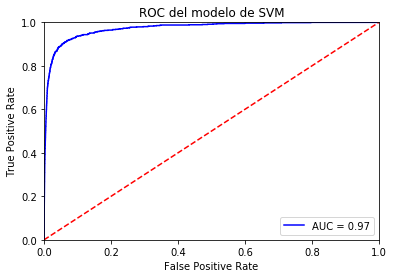

In [30]:
#Calculo del ERR y del umbral de decisión global
err, thresh = evaluate_EER_Thresh(genuine_scores, impostor_scores)

#Ploteamos la curva ROC de los umbrales
plotCurveROC(genuine_scores, impostor_scores, title = "ROC del modelo de SVM")

### Umbral de decisión global hallado (en formato score)

In [31]:
thresh

array(0.5375694)

### Respectiva tasa de error que nos daria el umbral de decisión

In [32]:
err

0.07852760736196218

In [33]:
users_evaluation['y_pred'] = np.where(users_evaluation['score'] >= thresh, 'genuine', 'impostor')

users_evaluation.to_excel("outputPredSVC.xlsx")

#Presentamos el calculo de resultados
users_evaluation

,user_model,user_id,score,std_score,y_test,y_pred
0,1,1,0.999992,0.999992,genuine,genuine
1,1,1,0.983240,0.983240,genuine,genuine
2,1,1,0.994465,0.994465,genuine,genuine
3,1,1,0.983834,0.983834,genuine,genuine
4,1,1,0.997355,0.997355,genuine,genuine
...,...,...,...,...,...,...
108390,133,132,0.106594,0.106594,impostor,impostor
108391,133,132,0.040755,0.040755,impostor,impostor
108392,133,133,0.804642,0.804642,genuine,genuine
108393,133,133,0.916016,0.916016,genuine,genuine


In [34]:
#Obtenemos los y_test y y_pred de nuestros resultados
y_test = users_evaluation.loc[:, "y_test"]
y_pred = users_evaluation.loc[:, "y_pred"]

### Precisión del umbral hallado

In [35]:
accuracy_score(y_test, y_pred)

0.9215000691913834

### TEST

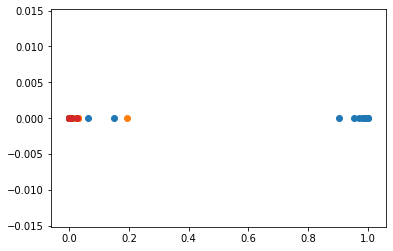

In [36]:
sc1 = users_evaluation.loc[(users_evaluation.user_model == 1) & (users_evaluation.user_id == 1), "std_score"]
sc2 = users_evaluation.loc[(users_evaluation.user_model == 1) & (users_evaluation.user_id == 2), "std_score"]
sc3 = users_evaluation.loc[(users_evaluation.user_model == 1) & (users_evaluation.user_id == 3), "std_score"]
sc4 = users_evaluation.loc[(users_evaluation.user_model == 1) & (users_evaluation.user_id == 4), "std_score"]

y1 = np.zeros(len(sc1))
y2 = np.zeros(len(sc2))
y3 = np.zeros(len(sc3))
y4 = np.zeros(len(sc4))

plt.scatter(sc1, y1)
plt.scatter(sc2, y2)
plt.scatter(sc3, y3)
plt.scatter(sc4, y4)

plt.show()

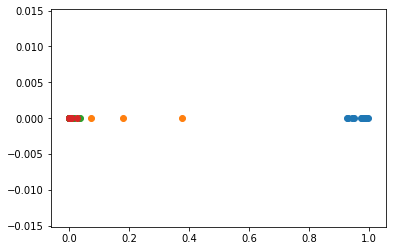

In [37]:
sc1 = users_evaluation.loc[(users_evaluation.user_model == 2) & (users_evaluation.user_id == 1), "std_score"]
sc2 = users_evaluation.loc[(users_evaluation.user_model == 2) & (users_evaluation.user_id == 2), "std_score"]
sc3 = users_evaluation.loc[(users_evaluation.user_model == 2) & (users_evaluation.user_id == 3), "std_score"]
sc4 = users_evaluation.loc[(users_evaluation.user_model == 1) & (users_evaluation.user_id == 4), "std_score"]

y1 = np.zeros(len(sc1))
y2 = np.zeros(len(sc2))
y3 = np.zeros(len(sc3))
y4 = np.zeros(len(sc4))

plt.scatter(sc2, y2)
plt.scatter(sc1, y1)
plt.scatter(sc3, y3)
plt.scatter(sc4, y4)

plt.show()

In [38]:
a = users_evaluation.min()["score"]

'{0:.0f}'.format(a)

'0'

In [39]:
a = users_evaluation.max()["score"]

'{0:.0f}'.format(a)


'1'

In [40]:
a = users_evaluation.min()["std_score"]

'{0:.8f}'.format(a)

'0.00000200'

In [41]:
a = users_evaluation.max()["std_score"]

'{0:.8f}'.format(a)

'0.99999998'

In [42]:
#df2['age_bmi'] = df.age * df.bmi

In [43]:
#Generar excel
#users_evaluation.to_excel("output.xlsx")

In [44]:
'''
from sklearn.calibration import CalibratedClassifierCV

isotonic_svc = CalibratedClassifierCV(
    base_estimator=SVC(kernel='linear', probability= False, random_state= 43),
    method='isotonic', cv= 5
) # isotonic calibration

isotonic_svc.fit(X_train, y_train)
y_prob2 = isotonic_svc.predict_proba(X_dev)
y_prob2

'''

"\nfrom sklearn.calibration import CalibratedClassifierCV\n\nisotonic_svc = CalibratedClassifierCV(\n    base_estimator=SVC(kernel='linear', probability= False, random_state= 43),\n    method='isotonic', cv= 5\n) # isotonic calibration\n\nisotonic_svc.fit(X_train, y_train)\ny_prob2 = isotonic_svc.predict_proba(X_dev)\ny_prob2\n\n"